<a href="https://colab.research.google.com/github/elichen/oai-playground/blob/main/Creating_slides_with_the_Assistants_API_and_DALL%C2%B7E_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
from openai import OpenAI
client = OpenAI(api_key=userdata.get('openai-key'))

In [4]:
def download_file(url, save_dir="."):
    os.makedirs(save_dir, exist_ok=True)
    file_name = os.path.basename(url)
    try:
        with open(os.path.join(save_dir, file_name), 'wb') as f:
            f.write(requests.get(url).content)
        print(f"Downloaded {file_name}")
    except:
        print(f"Failed to download {file_name}")

In [94]:
from IPython.display import display, Image
import os
import pandas as pd
import json
import io
from PIL import Image
import requests

#Lets import some helper functions for assistants from https://cookbook.openai.com/examples/assistants_api_overview_python
def show_json(obj):
    display(json.loads(obj.model_dump_json()))

def submit_message(assistant_id, thread, user_message,file_ids=None):
    params = {
        'thread_id': thread.id,
        'role': 'user',
        'content': user_message,
    }
    if file_ids:
        params["attachments"] = [
          {
            "file_id": x,
            "tools": [{"type": "code_interpreter"}]
          } for x in file_ids
        ]

    client.beta.threads.messages.create(
        **params
)
    return client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant_id,
)

def get_response(thread):
    return client.beta.threads.messages.list(thread_id=thread.id)

In [6]:
url = "https://github.com/openai/openai-cookbook/raw/main/examples/data/NotRealCorp_financial_data.json"
download_file(url)

Downloaded NotRealCorp_financial_data.json


In [8]:
financial_data_path = 'NotRealCorp_financial_data.json'
financial_data = pd.read_json(financial_data_path)
financial_data.head(5)

,Year,Quarter,Distribution channel,Revenue ($M),Costs ($M),Customer count,Time
0,2021,Q1,Online Sales,1.50,1.301953,150,2021 Q1
1,2021,Q1,Direct Sales,1.50,1.380809,151,2021 Q1
2,2021,Q1,Retail Partners,1.50,1.348246,152,2021 Q1
3,2021,Q2,Online Sales,1.52,1.308608,152,2021 Q2
4,2021,Q2,Direct Sales,1.52,1.413305,153,2021 Q2


In [34]:
file = client.files.create(
  file=open('NotRealCorp_financial_data.json',"rb"),
  purpose='assistants',
)

In [62]:
assistant = client.beta.assistants.create(
  instructions="You are a data scientist assistant. When given data and a query, write the proper code and create the proper visualization",
  model="gpt-4o",
  tools=[{"type": "code_interpreter"}],
  tool_resources={
    "code_interpreter": {
      "file_ids": [file.id]
    }
  }
)

In [63]:
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "Calculate profit (revenue minus cost) by quarter and year, and visualize as a line plot across the distribution channels, where the colors of the lines are green, light red, and light blue",
      "attachments": [
        {
          "file_id": file.id,
          "tools": [{"type": "code_interpreter"}]
        }
      ]
    }
  ]
)

In [64]:

run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
)


In [65]:
messages = client.beta.threads.messages.list(thread_id=thread.id)


In [66]:
import time

while True:
    messages = client.beta.threads.messages.list(thread_id=thread.id)
    try:
        if messages.data and messages.data[0].content:
            content = messages.data[0].content[0]
            if hasattr(content, 'text') and hasattr(content.text, 'value'):
                print(content.text.value)
        #See if image has been created
        messages.data[0].content[0].image_file
        #Sleep to make sure run has completed
        time.sleep(5)
        print('Plot created!')
        break
    except:
        time.sleep(10)
        print('Assistant still working...')


Let's start by loading and inspecting the data to understand its structure. We'll then identify the relevant columns for calculating profit, quarters, and distribution channels.

Let's begin by loading the data.
Assistant still working...
We now have the profit summarized by year, quarter, and distribution channel.

Next, let's visualize this data as a line plot where the colors of the lines are green, light red, and light blue for each distribution channel, respectively.
Assistant still working...
Assistant still working...
Plot created!


In [67]:
messages = client.beta.threads.messages.list(thread_id=thread.id)
[message.content[0] for message in messages.data]

[ImageFileContentBlock(image_file=ImageFile(file_id='file-dacx5HJhapNrsf8qM30Rlly7', detail=None), type='image_file'),
 TextContentBlock(text=Text(annotations=[], value="We now have the profit summarized by year, quarter, and distribution channel.\n\nNext, let's visualize this data as a line plot where the colors of the lines are green, light red, and light blue for each distribution channel, respectively."), type='text'),
 TextContentBlock(text=Text(annotations=[], value="The data was loaded correctly as a JSON file. The columns are:\n\n- `Year`\n- `Quarter`\n- `Distribution channel`\n- `Revenue ($M)`\n- `Costs ($M)`\n- `Customer count`\n- `Time`\n\nWe can now proceed to calculate the profit (revenue minus cost) by quarter and year, and then visualize it across the distribution channels.\n\nLet's calculate the profit first."), type='text'),
 TextContentBlock(text=Text(annotations=[], value="It appears the dataset didn't load correctly. The data seems to be in JSON format or improperly

In [68]:
# Quick helper function to convert our output file to a png
def convert_file_to_png(file_id, write_path):
    data = client.files.content(file_id)
    data_bytes = data.read()
    with open(write_path, "wb") as file:
        file.write(data_bytes)

In [70]:
plot_file_id = messages.data[0].content[0].image_file.file_id
image_path = "NotRealCorp_chart.png"
convert_file_to_png(plot_file_id,image_path)

#Upload
plot_file = client.files.create(
  file=open(image_path, "rb"),
  purpose='assistants'
)

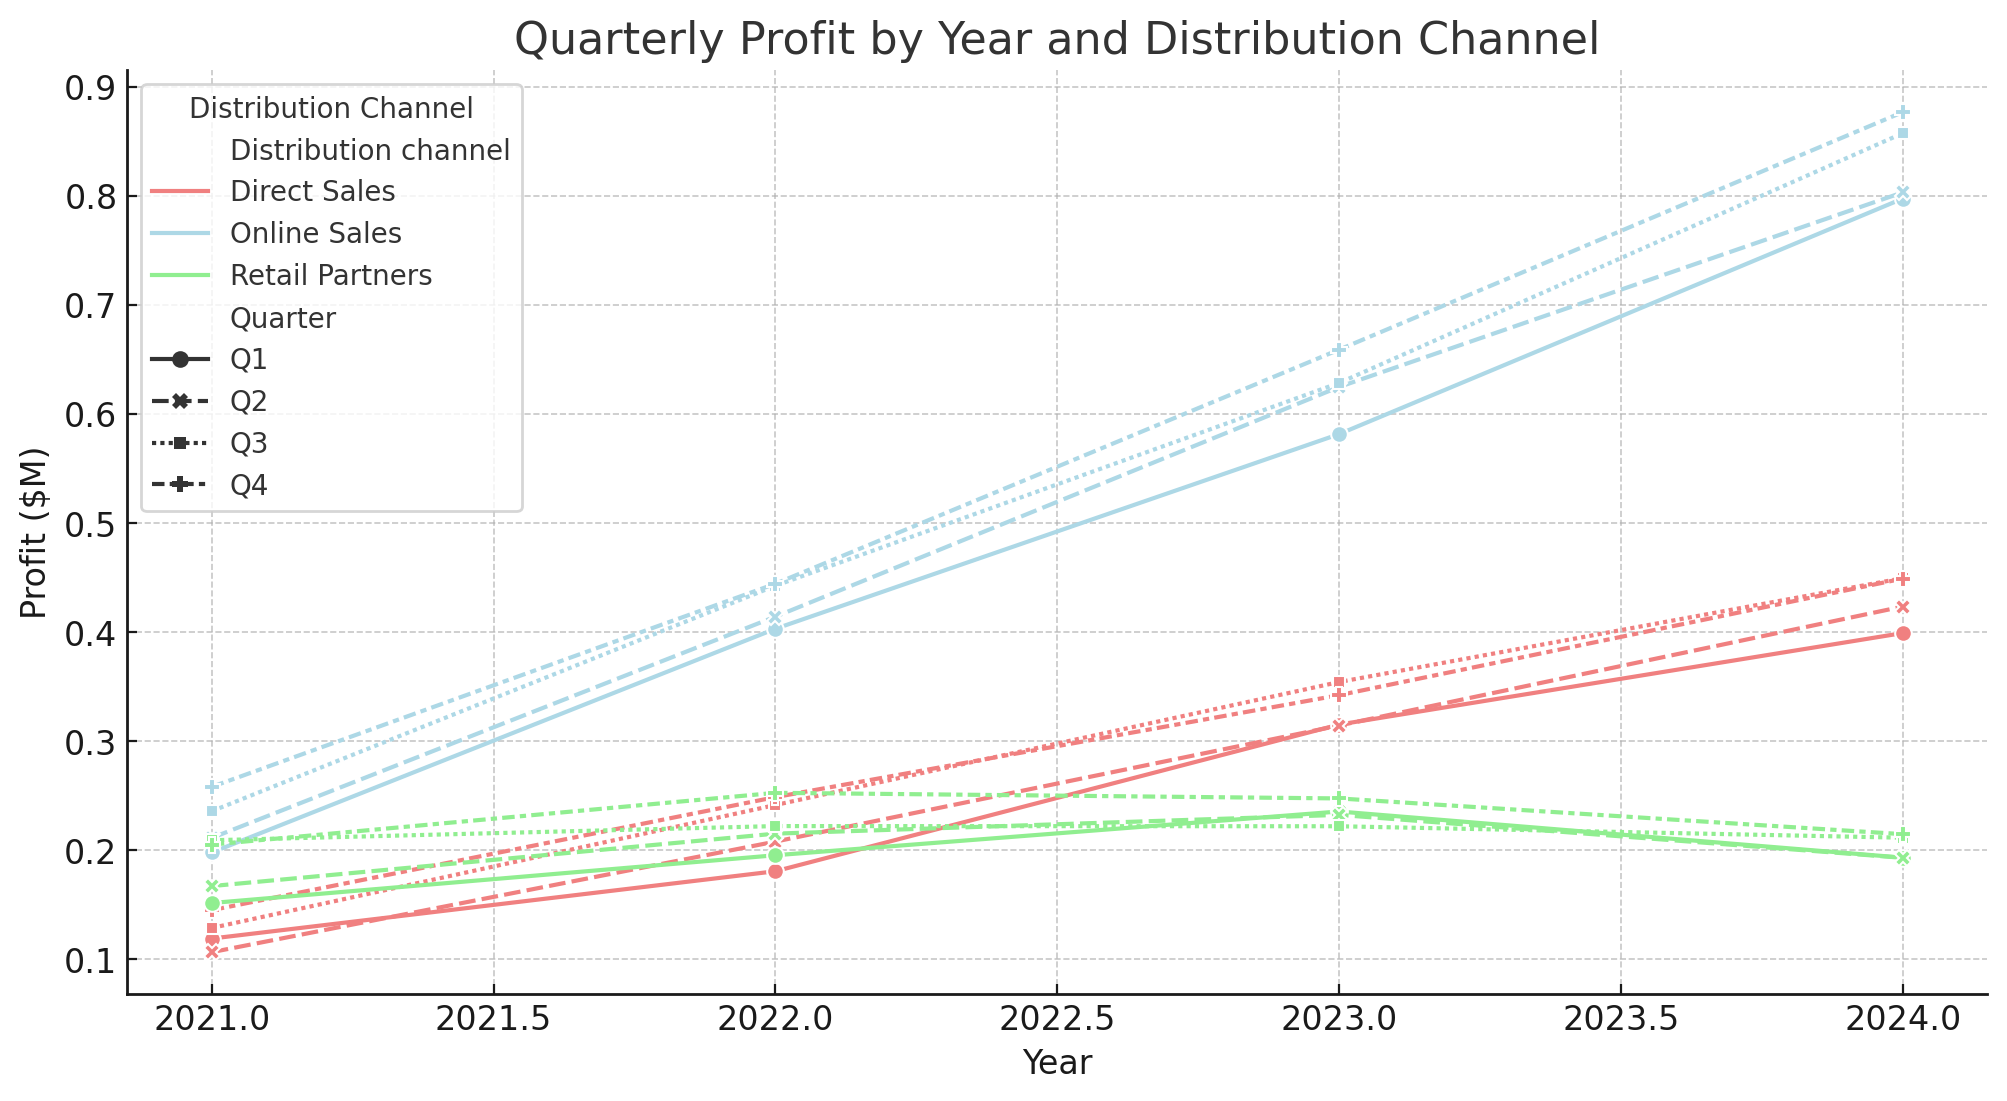

In [73]:
Image.open(image_path)

In [74]:
submit_message(assistant.id,thread,"Give me two medium length sentences (~20-30 words per sentence) of the \
      most important insights from the plot you just created.\
             These will be used for a slide deck, and they should be about the\
                     'so what' behind the data."
)

Run(id='run_eTvBUyQdsAl6ombyXpl6DzH1', assistant_id='asst_M51gLOQvKljnK3wclhYE6eky', cancelled_at=None, completed_at=None, created_at=1720049046, expires_at=1720049646, failed_at=None, incomplete_details=None, instructions='You are a data scientist assistant. When given data and a query, write the proper code and create the proper visualization', last_error=None, max_completion_tokens=None, max_prompt_tokens=None, metadata={}, model='gpt-4o', object='thread.run', parallel_tool_calls=True, required_action=None, response_format='auto', started_at=None, status='queued', thread_id='thread_I1nwkQhnj2VUBjwwWaOj9CrD', tool_choice='auto', tools=[CodeInterpreterTool(type='code_interpreter')], truncation_strategy=TruncationStrategy(type='auto', last_messages=None), usage=None, temperature=1.0, top_p=1.0, tool_resources={})

In [75]:
# Hard coded wait for a response, as the assistant may iterate on the bullets.
time.sleep(10)
response = get_response(thread)
bullet_points = response.data[0].content[0].text.value
print(bullet_points)

The plot reveals that Online Sales consistently yielded the highest profits across all quarters and years, indicating this channel's strong performance and market reach. Conversely, Retail Partners, while maintaining steady profits, showed a slight decline towards 2024, suggesting potential challenges or shifts in this distribution method that may need addressing.


In [76]:
submit_message(assistant.id,thread,"Given the plot and bullet points you created,\
 come up with a very brief title for a slide. It should reflect just the main insights you came up with."
)

Run(id='run_4FdrvnPAqllqlrmJ31oWJFe8', assistant_id='asst_M51gLOQvKljnK3wclhYE6eky', cancelled_at=None, completed_at=None, created_at=1720049076, expires_at=1720049676, failed_at=None, incomplete_details=None, instructions='You are a data scientist assistant. When given data and a query, write the proper code and create the proper visualization', last_error=None, max_completion_tokens=None, max_prompt_tokens=None, metadata={}, model='gpt-4o', object='thread.run', parallel_tool_calls=True, required_action=None, response_format='auto', started_at=None, status='queued', thread_id='thread_I1nwkQhnj2VUBjwwWaOj9CrD', tool_choice='auto', tools=[CodeInterpreterTool(type='code_interpreter')], truncation_strategy=TruncationStrategy(type='auto', last_messages=None), usage=None, temperature=1.0, top_p=1.0, tool_resources={})

In [77]:
#Wait as assistant may take a few steps
time.sleep(10)
response = get_response(thread)
title = response.data[0].content[0].text.value
print(title)

"Online Sales Drive Growth, Retail Partners Show Decline"


In [78]:
company_summary = "NotReal Corp is a prominent hardware company that manufactures and sells processors, graphics cards and other essential computer hardware."


In [79]:
response = client.images.generate(
  model='dall-e-3',
  prompt=f"given this company summary {company_summary}, create an inspirational \
    photo showing the growth and path forward. This will be used at a quarterly\
       financial planning meeting",
       size="1024x1024",
       quality="hd",
       n=1
)
image_url = response.data[0].url


In [80]:
dalle_img_path = 'dalle_image.png'
img = requests.get(image_url)

#Save locally
with open(dalle_img_path,'wb') as file:
  file.write(img.content)

#Upload
dalle_file = client.files.create(
  file=open(dalle_img_path, "rb"),
  purpose='assistants'
)


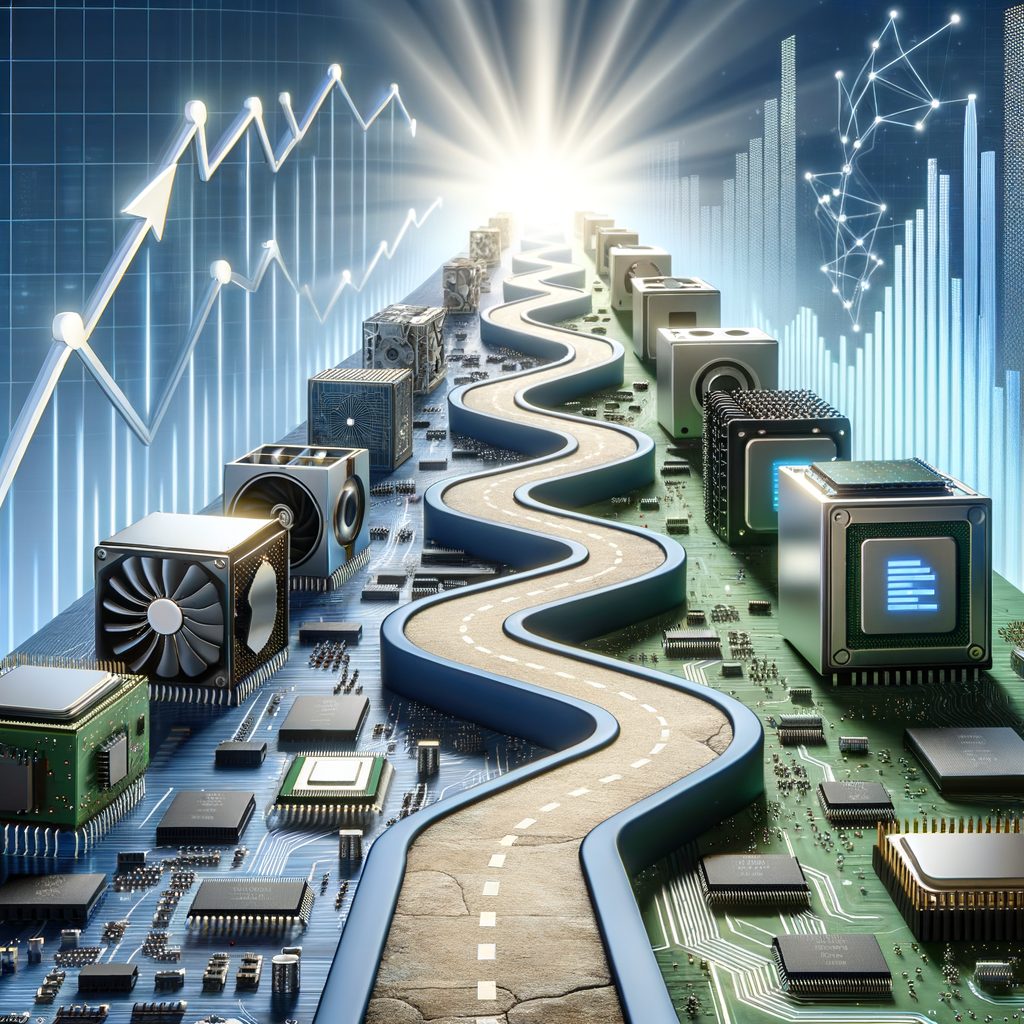

In [81]:
Image.open(dalle_img_path)

In [82]:
title_template = """
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_PARAGRAPH_ALIGNMENT
from pptx.dml.color import RGBColor

# Create a new presentation object
prs = Presentation()

# Add a blank slide layout
blank_slide_layout = prs.slide_layouts[6]
slide = prs.slides.add_slide(blank_slide_layout)

# Set the background color of the slide to black
background = slide.background
fill = background.fill
fill.solid()
fill.fore_color.rgb = RGBColor(0, 0, 0)

# Add image to the left side of the slide with a margin at the top and bottom
left = Inches(0)
top = Inches(0)
height = prs.slide_height
width = prs.slide_width * 3/5
pic = slide.shapes.add_picture(image_path, left, top, width=width, height=height)

# Add title text box positioned higher
left = prs.slide_width * 3/5
top = Inches(2)
width = prs.slide_width * 2/5
height = Inches(1)
title_box = slide.shapes.add_textbox(left, top, width, height)
title_frame = title_box.text_frame
title_p = title_frame.add_paragraph()
title_p.text = title_text
title_p.font.bold = True
title_p.font.size = Pt(38)
title_p.font.color.rgb = RGBColor(255, 255, 255)
title_p.alignment = PP_PARAGRAPH_ALIGNMENT.CENTER

# Add subtitle text box
left = prs.slide_width * 3/5
top = Inches(3)
width = prs.slide_width * 2/5
height = Inches(1)
subtitle_box = slide.shapes.add_textbox(left, top, width, height)
subtitle_frame = subtitle_box.text_frame
subtitle_p = subtitle_frame.add_paragraph()
subtitle_p.text = subtitle_text
subtitle_p.font.size = Pt(22)
subtitle_p.font.color.rgb = RGBColor(255, 255, 255)
subtitle_p.alignment = PP_PARAGRAPH_ALIGNMENT.CENTER
"""

data_vis_template = """
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_PARAGRAPH_ALIGNMENT
from pptx.dml.color import RGBColor

# Create a new presentation object
prs = Presentation()

# Add a blank slide layout
blank_slide_layout = prs.slide_layouts[6]
slide = prs.slides.add_slide(blank_slide_layout)

# Set the background color of the slide to black
background = slide.background
fill = background.fill
fill.solid()
fill.fore_color.rgb = RGBColor(0, 0, 0)

# Define placeholders
image_path = data_vis_img
title_text = "Maximizing Profits: The Dominance of Online Sales & Direct Sales Optimization"
bullet_points = "• Online Sales consistently lead in profitability across quarters, indicating a strong digital market presence.\n• Direct Sales show fluctuations, suggesting variable performance and the need for targeted improvements in that channel."

# Add image placeholder on the left side of the slide
left = Inches(0.2)
top = Inches(1.8)
height = prs.slide_height - Inches(3)
width = prs.slide_width * 3/5
pic = slide.shapes.add_picture(image_path, left, top, width=width, height=height)

# Add title text spanning the whole width
left = Inches(0)
top = Inches(0)
width = prs.slide_width
height = Inches(1)
title_box = slide.shapes.add_textbox(left, top, width, height)
title_frame = title_box.text_frame
title_frame.margin_top = Inches(0.1)
title_p = title_frame.add_paragraph()
title_p.text = title_text
title_p.font.bold = True
title_p.font.size = Pt(28)
title_p.font.color.rgb = RGBColor(255, 255, 255)
title_p.alignment = PP_PARAGRAPH_ALIGNMENT.CENTER

# Add hardcoded "Key Insights" text and bullet points
left = prs.slide_width * 2/3
top = Inches(1.5)
width = prs.slide_width * 1/3
height = Inches(4.5)
insights_box = slide.shapes.add_textbox(left, top, width, height)
insights_frame = insights_box.text_frame
insights_p = insights_frame.add_paragraph()
insights_p.text = "Key Insights:"
insights_p.font.bold = True
insights_p.font.size = Pt(24)
insights_p.font.color.rgb = RGBColor(0, 128, 100)
insights_p.alignment = PP_PARAGRAPH_ALIGNMENT.LEFT
insights_frame.add_paragraph()


bullet_p = insights_frame.add_paragraph()
bullet_p.text = bullet_points
bullet_p.font.size = Pt(12)
bullet_p.font.color.rgb = RGBColor(255, 255, 255)
bullet_p.line_spacing = 1.5
"""

In [83]:
title_text = "NotRealCorp"
subtitle_text = "Quarterly financial planning meeting, Q3 2023"

In [95]:
submit_message(assistant.id,thread,f"Use the included code template to create a PPTX slide that follows the template format, but uses the image, company name/title, and document name/subtitle included:\
{title_template}. IMPORTANT: Use the image file included in this message as the image_path image in this first slide, and use the Company Name {title_text} as the title_text variable, and \
  use the subtitle_text {subtitle_text} a the subtitle_text variable. \
    NEST, create a SECOND slide using the following code template: {data_vis_template} to create a PPTX slide that follows the template format, but uses the company name/title, and document name/subtitle included:\
{data_vis_template}. IMPORTANT: Use the line plot image, that is the second attached image in this message, that you created earlier in the thread as the data_vis_img image, and use the data visualization title that you created earlier for the variable title_text, and\
  the bullet points of insights you created earlier for the bullet_points variable. Output these TWO SLIDES as a .pptx file. Make sure the output is two slides, with each slide matching the respective template given in this message.",
              file_ids=[dalle_file.id, plot_file.id]
)


Run(id='run_J7gHMNfNRMJVolPl47m4z2oM', assistant_id='asst_M51gLOQvKljnK3wclhYE6eky', cancelled_at=None, completed_at=None, created_at=1720049583, expires_at=1720050183, failed_at=None, incomplete_details=None, instructions='You are a data scientist assistant. When given data and a query, write the proper code and create the proper visualization', last_error=None, max_completion_tokens=None, max_prompt_tokens=None, metadata={}, model='gpt-4o', object='thread.run', parallel_tool_calls=True, required_action=None, response_format='auto', started_at=None, status='queued', thread_id='thread_I1nwkQhnj2VUBjwwWaOj9CrD', tool_choice='auto', tools=[CodeInterpreterTool(type='code_interpreter')], truncation_strategy=TruncationStrategy(type='auto', last_messages=None), usage=None, temperature=1.0, top_p=1.0, tool_resources={})

In [96]:
#May take 1-3 mins
while True:
    try:
        response = get_response(thread)
        pptx_id = response.data[0].content[0].text.annotations[0].file_path.file_id
        print("Successfully retrieved pptx_id:", pptx_id)
        break
    except Exception as e:
        print("Assistant still working on PPTX...")
        time.sleep(10)


Assistant still working on PPTX...
Assistant still working on PPTX...
Successfully retrieved pptx_id: file-Zglho3AIPNz3W0sO6UIRZW4C


In [99]:
pptx_id = response.data[0].content[0].text.annotations[0].file_path.file_id
ppt_file= client.files.content(pptx_id)
file_obj = io.BytesIO(ppt_file.read())
with open("created_slides.pptx", "wb") as f:
    f.write(file_obj.getbuffer())